<a href="https://colab.research.google.com/github/AndreasICL/MSc_Project/blob/master/code/VFF_and_RFF_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gpflow
!pip install gast
#helloworld

In [0]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

from gpflow.config import default_float
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.base import TensorLike
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl

import warnings

warnings.filterwarnings("ignore")

Make `tensorboard` work inside notebook:

In [0]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = pathlib.Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Set up random seeds and default float for `gpflow` tensors:

In [0]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

## Loading data using TensorFlow Datasets

For this example, we create a synthetic dataset (noisy sine function):

In [0]:
def noisy_sin(x):
    return tf.math.sin(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())

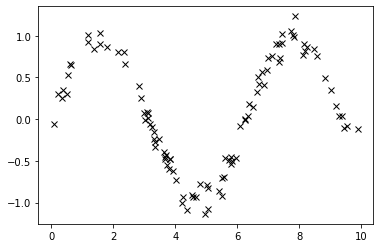

In [0]:
def noisy_sin(x):
    return tf.math.sin(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())


num_train_data, num_test_data = 100, 500

X = tf.random.uniform((num_train_data, 1), dtype=default_float()) * 10
Xtest = tf.random.uniform((num_test_data, 1), dtype=default_float()) * 10

Y = noisy_sin(X)
Ytest = noisy_sin(Xtest)

data = (X, Y)

plt.plot(X, Y, "xk")
plt.show()

Working with TensorFlow Datasets is an efficient way to rapidly shuffle, iterate, and batch from data. For `prefetch` size we use `tf.data.experimental.AUTOTUNE` as recommended by TensorFlow [guidelines](https://www.tensorflow.org/guide/data_performance).

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))

batch_size = 32
num_features = 10
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = (
    train_dataset.repeat()
    .prefetch(prefetch_size)
    .shuffle(buffer_size=shuffle_buffer_size)
    .batch(batch_size)
)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=-1
shuffle_buffer_size=50
num_batches_per_epoch=3


## Define a GP model

In GPflow 2.0, we use `tf.Module` (or the very thin `gpflow.base.Module` wrapper) to build all our models, as well as their components (kernels, likelihoods, parameters, and so on).

### 1D Random Variational Fourier Feature Class

In [0]:
class RVFF_1D(gpflow.inducing_variables.InducingVariables):
    def __init__(self, a, b, M):
        # [a, b] defining the interval of the Fourier representation:
        self.a = gpflow.Parameter(a, dtype=gpflow.default_float())
        self.b = gpflow.Parameter(b, dtype=gpflow.default_float())
        # integer array defining the frequencies, ω_m = 2π (b - a)/m:
        self.omegas = 2.0 * np.pi * np.arange(M, dtype=default_float()) / (b - a) + 1 # TODO: fix this
        self.phis = np.random.multivariate_normal( mean=a * np.ones( shape=M ), cov=np.identity( M ) )

    def __len__(self):
        """ number of inducing variables (defines dimensionality of q(u)) """ 
        return len(self.omegas)  # M sine components

In [0]:
@cov.Kuu.register(RVFF_1D, gpflow.kernels.Matern12)
def Kuu_matern12_RVFF_1D(inducing_variable, kernel, jitter=None):
    a, b, omegas, phis = (lambda u: (u.a, u.b, u.omegas, u.phis))(inducing_variable)
    
    lambda_ = 1.0 / kernel.lengthscales

    def innerProduct( intervalLen, omegas, phis, kernelVar, lambda_):
      angle1 = intervalLen * ( omegas[:, None] - omegas[None, :] ) + omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
      angle2 = intervalLen * ( omegas[:, None] + omegas[None, :] ) + omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
      angle3 = omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
      angle4 = omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
      
      coeff1 = ( omegas[:, None] * omegas[None, :] + lambda_ * lambda_ ) / ( omegas[:, None] - omegas[None, :] )
      coeff2 = ( omegas[:, None] * omegas[None, :] - lambda_ * lambda_ ) / ( omegas[:, None] + omegas[None, :] )

      firstTerm = ( coeff1 * tf.sin( angle1 ) +
                    coeff2 * tf.sin( angle2 ) -
                    lambda_ * tf.cos( angle2 ) +
                    lambda_ * tf.cos( angle1 ) +
                    coeff1 * tf.sin( angle3 ) +
                    coeff2 * tf.sin( angle4 ) -
                    lambda_ * tf.cos( angle4 ) +
                    lambda_ * tf.cos( angle3 ) ) / ( 4 * kernelVar * kernelVar * lambda_ )
      print(coeff1)
      print(coeff2)
      secondTerm = tf.sin( omegas[:, None] * phis[:, None] ) * tf.sin( omegas[None, :] * phis[None, :] ) / ( kernelVar * kernelVar )
      print(firstTerm)
      return firstTerm + secondTerm

    return innerProduct( b - a, omegas, phis, kernel.variance, lambda_ )

@cov.Kuf.register(RVFF_1D, gpflow.kernels.Matern12, TensorLike)
def Kuf_matern12_RVFF_1D(inducing_variable, kernel, X):
    X = tf.squeeze(X, axis=1)
    a, omegas, phis = (lambda u: (u.a, u.omegas, u.phis))(inducing_variable)       
    return tf.cos( omegas[:, None] * ( X[None, :] - a + phis[:, None]) )

In [0]:
tf.config.experimental_run_functions_eagerly(True)

kernel = gpflow.kernels.Matern12(variance=1.0, lengthscales=1.0)
likelihood = gpflow.likelihoods.Gaussian()

inducing_variable = RVFF_1D( a=2, b=6, M=10 ) # gpflow.inducing_variables.InducingPoints(Z)

model = gpflow.models.SVGP(
    kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable
)

optimizer = tf.optimizers.Adam()

@tf.function
def loss_closure():
  return -model.elbo( ( X, Y ) )

optimizer.minimize( loss=loss_closure, var_list=model.trainable_variables )

tf.Tensor(
[[          inf   -2.27323954   -1.63661977   -1.42441318   -1.31830989
    -1.25464791   -1.21220659   -1.18189136   -1.15915494   -1.14147106]
 [   2.27323954           inf   -7.4148322    -4.99281426   -4.18547495
    -3.78180529   -3.5396035    -3.37813564   -3.26280145   -3.17630081]
 [   1.63661977    7.4148322            inf  -15.69801751   -9.91980508
    -7.99373427   -7.03069887   -6.45287762   -6.06766346   -5.79251049]
 [   1.42441318    4.99281426   15.69801751           inf  -27.12279547
   -16.41759222  -12.84919114  -11.0649906    -9.99447028   -9.28079006]
 [   1.31830989    4.18547495    9.91980508   27.12279547           inf
   -41.68916608  -24.48617569  -18.75184556  -15.8846805   -14.16438146]
 [   1.25464791    3.78180529    7.99373427   16.41759222   41.68916608
            inf  -59.39712935  -34.12555549  -25.70169754  -21.48976856]
 [   1.21220659    3.5396035     7.03069887   12.84919114   24.48617569
    59.39712935           inf  -80.24668527  -4

InvalidArgumentError: ignored